# Quantum Game Theory

In [184]:
#Run this cell once to load all the relevant packages and settings
%load_ext autoreload
%autoreload 2

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit.extensions import XGate, HGate
from QuantumGameTheory import Game
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cool picture

## What you will learn in this tutorial

Fun intro - teach you how to be a quantum game creator
* What is a "Game Theory" game
* What is a "Quantum Game theory" game and how can I study these types of games using qiskit

## Game Theory
intro w/ John Nash (rec letter). Players play a game in which they make choices (i.e. pick strategies) in order to maximize their points (i.e. their payoffs). The best way to get introduced to game theory is to start playing a game, soo let's dive straight in! 

### The Prisoner's Dilemma

Probably the most famous game theoretical game is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma). There are many variants to this game each with their own story, so here's our story for the game:

Both you and I team up to break into a zoo and steal a panda (just for a little bit, we were going to give it back!). Unfortunately we both get caught, but not quite redhanded, so it isn't such an open-and-shut case for the police. So in order to try and get a confession out of both of us, the police seperate us into different rooms and give each of us two options:
* To remain silent and take our chances - we shall call this strategy '0'
* To confess and maybe receive a reduced sentence - we shall call this strategy '1'

So together, there are 4 possible outcomes that could happen: '00' (where we both remain silent), '01' (where you remain silent and I confess), '10' (where you confess and I remain silent) and '11' (where we both confess).
We are told that if we both remain silent (i.e. end up at the '00' outcome), the police still have enough evidence sentence us to 1 month in prison. However, if one of us confesses (i.e. the outcome is either '01' or '10') the player who chose the '1' strategy goes free and the other player (who chose the strategy '0') receives a 3 month prison sentence. "What if we both confess, i.e. the outcome is '11'?" I hear you ask. In which case, the policement informs us that we each get a 2 month prison sentence. I know there's a lot going on, so don't worry if you can't remember it all. It will become much clearer as we start coding right now!

Finally, on to some coding! Throughout this notebook, we will be using the 'QuantumGameTheory' package. So without further ado, let us create the prisoner's dilemma game object by simply calling it:

In [167]:
prisoner_game = Game(game_name='prisoner',protocol="Classical")

The 'game_name' indicates which game to load. Don't worry about the 'protocol' for now (as you might have guessed, we will use this later on when making a quantum version of the game). Now before we play the game, let's have a look at the possible payoffs

In [168]:
prisoner_game.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


This shows us the outcomes represented in bits and the payoff for each outcome e.g. if you remain silent ('0') and I confess ('1'), the outcome is represented by the bits '01' and the corresponding payoff is '[-3, 0]' which indicates that you will be sentenced to 3 months prison and I will go free (i.e. get 0 months prison). Notice that the payoff for you is -3 and not 3. This is because players are always trying to maximize their payoff, so the more months in prison will give you more negative results. 

So let's play! You will be P1 and I will be P2. To run the game, we simply have to input our strategies into the 'play_game' method and the results will be displayed. Feel free to try the different strategies for both players (ignore the 'outcomes' variable and 'num_times' column for now. We will get back to them way later on). 

In [192]:
P1_strategy = 1#fill in here
P2_strategy = 1
combined_strategies = [P1_strategy, P2_strategy]
outcomes, results = prisoner_game.play_game(combined_strategies)
results

,outcome,payoffs,winners,num_times,backend
0,11,"(-2, -2)",no winners,1,Classical


__Exercise 1__: What strategy would you choose if you didn't know what strategy I was going to choose? This can be a bit tricky but it is worth taking the time to think about it before looking at the answer!

<details>
<summary>Click here for the answer to Exercise 1</summary>
No matter what strategy I choose, the optimal strategy for you is 1 (i.e. to confess). To understand this, let's look at the options starting with my strategies:
<ol>
  <li>I choose strategy 0 i.e. remain silent. If you also choose 0, your payoff is -1 whereas if you choose 1, your payoff is 0. Therefore it is better for you to choose 1 in this case.</li>
  <li>I choose strategy 1 i.e. confess. If you choose 0, your payoff is -3 whereas if you also choose 1, your payoff is -2. Therefore it is also better for you to choose 1 in this case.</li>
</ol>
So it is always better for you to choose 1. By symmetry, this logic works for both of us (i.e. it is also better for me to always choose 1 since if I become P1 and you become P2, the payoffs remain the same). Therefore, rationally speaking, we should both always choose option 1. This leads to the concept of the 'dominant strategy' - the strategy that we will choose <i>regardless of what the other person chooses</i> (in this case 1 for the both of us). We say that this game has a 'dominant strategy equilibrium state' with the outcome 11 and payoffs [-2, -2].  
</details>

### Nash Equilibria

In this section, we investigate the most popular type of equilibrium - the Nash equilibrium. In order to do this, we will look at another game - Bach or Stravinsky. The game is as follows: Two people (Alya and Bai) want to go out to a concert. One prefers Bach and the other Stravinksy. However, they both would prefer to go together rather than to either concert alone. To see this quantitatively, let's look at the payoff table.

In [173]:
BoS_game = Game(game_name='BoS',protocol="Classical")
BoS_game.display_payoffs()

Game: BoS
Payoffs: 


,outcome,payoffs
0,00,"(3, 2)"
1,01,"(0, 0)"
2,10,"(0, 0)"
3,11,"(2, 3)"


To start with, we see that there is no dominant strategy equilibrium - neither player has a strategy that will give them the best outcome regardless of the other player's strategy. On the other hand, we know that there are some strategies that are better than others _if a player knows what the other player is going to do_. In this example, say Bai knew that Alya was going to the Bach concert (strategy 0), then he will choose to also go to the Bach concert (because he would rather get a payoff of 2 than 0).

The question is, are there pairs of strategies for which no player would change if the other one was fixed? I.e. is there a combined strategy 'a', 'b' such that if Alya chooses strategy 'a', then Bai will choose strategy 'b' _and_ if Bai chooses strategy 'b', then Alya will choose strategy 'a'? If this is the case, we say that Alya and Bai are in a Nash equilibrium.

__Exercise 2__: What are the Nash equiblibria in the Bach or Stravinsky game?

<details>
<summary>Click here for the answer to Exercise 2</summary>
The two strategies that Alya and Bai can choose that lead to Nash equilibria are '00' or '11'. Let's look at the first one from each of the players' points of view:
<ol>
    <li> If Alya knew that Bai was going to pick 0 (i.e. go to the Bach concert), then she would also pick 0 to maximize her payoff.</li>
    <ii> If Bai knew that Alya was going to pick 0, then he would also pick 0 to maximize his payoff.</li>
</ol>
Therefore, neither player will deviate from their strategies. The same applies for the '11' strategy

__Exercise 3__: Are dominant strategy equilibria Nash equilibria? What about vice-versa? (If you're not sure what dominant strategy equilibria are, have a look at the answer to Exercise 1)

<details>
<summary>Click here for the answer to Exercise 3</summary>
    Dominante equilibria are also <i>always</i> Nash equilibria - if the players each choose the dominant strategy, they also will not change their strategies if they know what the other player is going to do, which by definition puts them in a Nash equilibrium. On the other hand, not all Nash equilibria are dominant strategy equilibria as can be seen using the Bach or Stravinsky game above

### General 2x2 Games

The prisoner's dilemma and Bach or Stravinksy game are known as a "2x2 games" - games in which there are 2 players and they each have the option between 2 strategies. So immediately we can see how to make any 2x2 game in principle - just make a list of payoffs for each outcome and you now have a game! So let's do it

In [ ]:
my_game_name = '' #fill in game name
my_payoff_table = {'00': [#, #], 
                   '01': [#, #],
                   '10': [#, #],
                   '11': [#, #]} #fill in payoffs
my_game = Game(my_game_name, protocol="Classical", payoff_table=my_payoff_table)
my_game.display_payoffs()

In [ ]:
P1_choice = #fill in here
P2_choice = #fill in here
choices = [P1_choice, P2_choice]
outcomes, results = my_game_game.play_game(choices)
results

Here ends our introduction to Game Theory. There are [many](https://www.youtube.com/watch?v=3Y1WpytiHKE), [many](http://web.mit.edu/rgibbons/www/Gibbons_An%20Introduction%20to%20Applicable%20Game%20Theory.pdf) [good](http://www.rasmusen.org/GI/download.htm) [resources](https://econweb.ucsd.edu/~jsobel/200Cs09/Kartik_Notes.pdf) out there to learn more about classical game theory. As far as this tutorial is concerned, we will end our discussion on classical game theory here. Now let's go quantum!

## Quantum Game Theory

Intro - Khan paper - started late 90s etc. EWL protocol

### The EWL protocol

Just as reminder, here is the protocol for a classical 2x2 game:
1. Initialization - we start with two '0' bits
2. Strategy - each player receives a bit a decides to either keep it as a 0 or flip it to a 1
3. Outcome - the outcome is the combination of the two bits
4. Payoff - the payoff table is used to find the payoff for each player given the outcome

Notice that steps 1 to 3 are the same no matter which 2x2 game we play and only the final step of determining the payoffs depends on teh specific game

When dealing with _quantum_ game theory, we require the quantum protocol to follow two rules: __Rule 1:__ It has to distribute maximally entangled qubits to the players and __Rule 2:__ it has to generalize the classical version of the game (don't worry if this doesn't make sense to you immediately, we will come back to these rules again). We will first give the recipe to turn a classical game theory game into a quantum game and then walk through how to implement it in Qiskit. Let's look at how to turn a 2x2 classical game into a quantum game.

__1. Intialization__ - we start with two '0' qubits and 2 classical bits that we will use to store measurement results. Ignoring the classical bits for now, this gives us $$|00\rangle $$ 
__2. Entanglement__ - we want the qubits to be maximally entangled to each other by an operator before we hand them off to the players. For now we will call this entangling operator $J$ (and explain it further later on). This gives us the state $$J|00\rangle $$
__3. Strategy__ - each player is then given a qubit and applies a single-qubit unitary operator of their choice to their qubit (as opposed to the classical version where they can only choose between keeping it or flipping it). Let's call these operators $U_1$ and $U_2$. We then end up with $$U_1U_2J|00\rangle $$ 
__4. 'Disentanglement'__- The qubits are then put through a 'disentangling' gate $J^{\dagger}$ - again we will get to why later on. So we now have $$J^{\dagger}U_1U_2J|00\rangle $$
__5. Measurement__ - the qubits are measured in the computational basis and the measurements are stored in the two classical bits

The final 2 steps are exactly the same as in the classical protocol

__6. Outcome__ - the outcome is the combination of the two (classical) bits <br>
__7. Payoff__ - the payoff table is used to find the payoff for each player given the outcome

Similar to the classical game, steps 1 to 6 are the same no matter which 2x2 game we play and only the final step of determining the payoffs depends on the specific game.

#### The Entangling Operator $J$

The choice of the entangling and 'disentangling' operators ($J$ and $J^{\dagger}$) comes from having to satisfy the two rules mentioned above. Here is a more detailed description of the rules:

__Rule 1__ : we need to pick an operator that leads to a maximally entangled state before distributing the qubits to each individual player and <br>
__Rule 2__ : when playing a quantum game, if both players' strategies are just combinations of either 'keeping it the same' i.e $I$, or 'flipping it' i.e. $X$, then the outcome of the game better be the same as if the players were playing the classical version of the game. This ensures that the classical game is contained within the quantum game.

We use the operator chosen by Hayden & Benjamin (without loss of generality): $$J = \frac{1}{\sqrt{2}} (I^{\otimes 2} + iX^{\otimes 2})$$ where $I$ is the identity operator and $X$ is the Pauli-X gate. Applying this operator to the state $|00\rangle$ results in the state $$\frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right)$$ which is a maximally entangled 2 qubit state.

__Exercise 4__: Show that adding the $J^{\dagger}$ operator at step 4 satisfies __Rule 2__. Hint: start by showing that  $J^{\dagger}$ commutes with $I^{\otimes 2}$ and $X{^\otimes 2}$. 

<details>
<summary>Click here for the answer to Exercise 4</summary>
First we show the commutation relations in the hint. <br>
$\begin{align}
    [J^{\dagger}, I^{\otimes 2}] &= J^{\dagger}I^{\otimes 2} - I^{\otimes 2}J^{\dagger} \\
    &= J^{\dagger} - J^{\dagger} \\
    &= 0 \\
    [J^{\dagger}, X^{\otimes 2}] &= J^{\dagger}X^{\otimes 2} - X^{\otimes 2}J^{\dagger} \\
    &= \frac{1}{\sqrt{2}} (I - iX^{\otimes 2})X^{\otimes 2} - X^{\otimes 2}\frac{1}{\sqrt{2}} (I^{\otimes 2} - iX^{\otimes 2}) \\
    &= \frac{1}{\sqrt{2}} (X^{\otimes 2} - iI^{\otimes 2}) - \frac{1}{\sqrt{2}} (X^{\otimes 2} - iI^{\otimes 2}) \\
    &= 0
\end{align}$

And since $X$ and $I$ commute, this means that $J^{\dagger}$ commutes with any combination of $I$ and $X$ (i.e. $I^{\otimes 2}$, $IX$, $XI$ and $X^{\otimes 2}$).
Now if we look back at step 4 of the protocol $$J^{\dagger}U_1U_2J|00\rangle $$ and impose that $U_1$ and $U_2$ are a combination of $I$ and $X$ gates, we can then move move then interchange the $J^{\dagger}$ operator with the $U_1$ and $U_1$ operators (since they all commute) which gives us $$U_1U_2J^{\dagger}J|00\rangle = U_1U_2|00\rangle.$$ This results in the final state being qubits that have either been 'kept the same' or 'flipped' without any entanglement or superposition states, which is exactly the same as what would happen in the classical version. This is why step for is called 'disentanglement' in quotation marks - the $J^{\dagger}$ gate disentangles the qubits if only $I$ or $X$ operators were used as strategies.

</details>

### Building a 2x2 quantum game

OK it's finally qiskit time! In this section, we will be implementing steps 1 to 5 (above)

#### 1. Initialziation
Initialize a circuit with two '0' qubits and 2 classical bits that we will use to store measurement results 

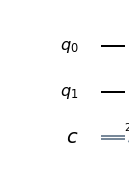

In [64]:
circ = QuantumCircuit(2,2)
circ.draw(output='mpl')

This gives a starting state of $|00\rangle $

#### 2. Entanglement
We maximally entangled to each other by inserting the J operator

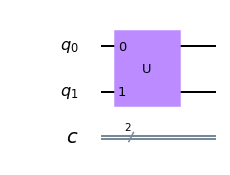

In [65]:
I_2 = np.identity(4)
    
X_2 = np.matrix([[0,0,0,1], 
                   [0,0,1,0],
                   [0,1,0,0],
                   [1,0,0,0]])
J_2 = Operator(1 / np.sqrt(2) * (I_2 + 1j *X_2))    

circ.append(J_2, [0,1])
circ.draw(output='mpl')

This leads us to the state $J|00\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right) $

__Exercise 5__: Calculate the 4x4 matrix for the $J$ operator and show that $J$ is a unitary operator

<details>
<summary>Click here for the answer to Exercise 5</summary>
Computing $J$:
$$I =  \left(\begin{array}{cccc} 1&0&0&0\\
                          0&1&0&0\\
                          0&0&1&0\\
                          0&0&0&1\end{array}\right)$$
$$iX =  \left(\begin{array}{cccc} 0&0&0&i\\
                          0&0&i&0\\
                          0&i&0&0\\
                          i&0&0&0\end{array}\right)$$
$$J = \frac{1}{\sqrt{2}} (I + iX) = \frac{1}{\sqrt{2}}\left(\begin{array}{cccc} 1&0&0&i\\
                                                                                0&1&i&0\\
                                                                                0&i&1&0\\
                                                                                i&0&0&1\end{array}\right)$$

Showing J is unitary:
    
$\begin{align}J^{\dagger}J &= \frac{1}{\sqrt{2}} (I - iX) \frac{1}{\sqrt{2}} (I + iX) \\
&= \frac{1}{2}(I - iX + iX + I) \\
&= I
\end{align}
$
</details>

#### 3. Strategy

Each person can perform a unitary operator on their individual qubit, e.g. player 1 chooses the $X$ and player 2 chooses the $S$ gate (the $S$ gate changes $|1\rangle \rightarrow i|1\rangle$ and does not do anything to $|0\rangle$)

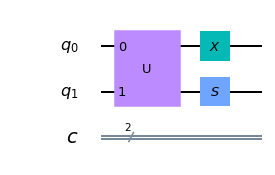

In [66]:
circ.x(0) #assign the X gate to player 1
circ.s(1) #assign the H gate to player 2
circ.draw(output='mpl')

#### 4. 'Disentanglement'

We now apply the $J^{\dagger}$ gate to satisfy __Rule 2__

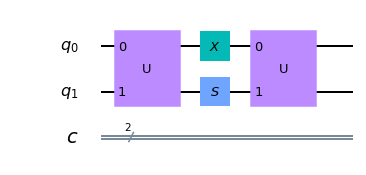

In [67]:
J_2_dg = Operator(1 / np.sqrt(2) * (I_2 - 1j *X_2))

circ.append(J_2_dg, [0,1])
circ.draw(output='mpl')

__Exercise 6__: What is the state of the qubits at this stage of the circuit?

<details>
<summary>Click here for the answer to Exercise 6</summary>
$\begin{align}
J^{\dagger}J &= J^{\dagger}X_1S_2J|00\rangle \\
&= J^{\dagger}X_1S_2\frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right) \\
&= J^{\dagger}\frac{1}{\sqrt{2}}\left(|10\rangle - |01\rangle\right) \\
&= \frac{1}{\sqrt{2}} (I^{\otimes 2} - iX^{\otimes 2})\frac{1}{\sqrt{2}}\left(|10\rangle - |01\rangle\right) \\
&= \frac{1}{2}\left(|10\rangle - |01\rangle - i|01\rangle + i|10\rangle\right) \\
&= \frac{1+i}{2}(|10\rangle -|01\rangle)
\end{align}$ <br>
So even though player 1 used the $X$ operator to flip their bit, they finally ended in a state that could lead to their final outcome being 0 or 1 with a 50% probability!
</details>

#### 5. 'Measurement'
And we then measure both qubits in the computational basis, saving the answers into the classical registers

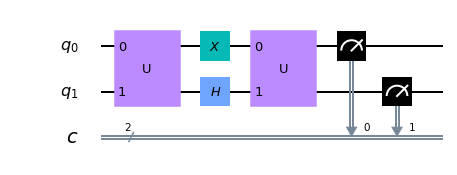

In [25]:
circ.measure([0,1], [0,1])
circ.draw(output='mpl')

Since the last two steps (outcome and payoff) do not involve any quantum processes we are done with building the quantum circuit for a 2x2 quantum game!

### Quantum Prisoner's Dilemma

Now that we have gone through how to write the circuit ourselves, we can use the inbuilt QuantumGameTheory package from now on to simplify the coding going forward. Let's spin up a quantum version of prisoner's dilemma. 

In [165]:
prisoner_game_quantum = Game(game_name='prisoner', protocol="EWL")
prisoner_game_quantum.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


Notice that the payoff table is identical to the classical version (as expected given the protocol described above). Now let us run the same strategies as above in this game

In [177]:
P1_strategy = 'X'
P2_strategy = 'S'
combined_strategies = [P1_strategy, P2_strategy]
outcomes, results = prisoner_game_quantum.play_game(combined_strategies)
results

,outcome,payoffs,winners,num_times,backend
0,01,"(-3, 0)",P2,1,qasm_simulator


This gives us the outcome of a single game. Let us play the game many times over (say 100) and see the results

In [178]:
outcomes_sim, results_sim = prisoner_game_quantum.play_game(combined_strategies, n_times = 100)
results_sim

,outcome,payoffs,winners,num_times,backend
0,01,"(-3, 0)",P2,51,qasm_simulator
1,10,"(0, -3)",P1,49,qasm_simulator


As a side note: we will finally use the 'outcomes_sim' variable and 'num_times column'! (you were told to ignore these at the very beginning of the tutorial... finally they're in use!). num_times refers to the number of times the given outcome appeared and 'outcomes_sim' is simply a dictionary of keys 'outcome' and values 'num_times' which is used as an input to qiskit's own 'plot_histogram' function.

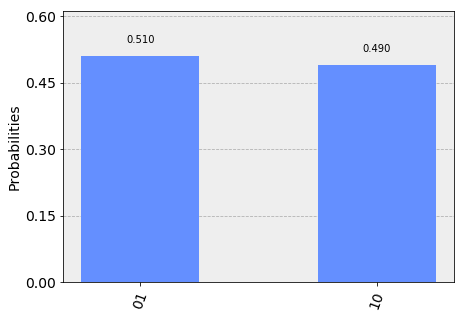

In [193]:
plot_histogram(outcomes_sim)

As you can see, we have about an even split between 01 and 10. Does the outcome make sense? At this point if you haven't done Exercise 6 yet, have a look at the solution to see why the outcome is like this and why, even though player one chose $X$ as their strategy, they still end up with an outcome of '0' half the time!

### Playing on an actual quantum computer

__If you haven't setup your IBMQ account, please click [here](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/fundamentals/1_getting_started_with_qiskit.ipynb) and go to the section titled 'Running circuits from the IBM Q account'__

So far we have been running everything on the QASM simulator (under the hood). Let's rerun the same game (quantum prisoner's dilemma) with the same strategies (player 1 choose $X$ and player 2 chooses $S$) on a real quantum computer this time! We can do this by simply adding the group and backend of the machine we desire when spinning up the game (this might take a while to run depending on the queue of the machine you select) 

In [181]:
prisoner_game_quantum = Game(game_name='prisoner', protocol="EWL", group='open', backend="ibmqx2")
P1_strategy = 'X'
P2_strategy = 'S'
combined_strategies = [P1_strategy, P2_strategy]
prisoner_game_quantum.play_game(combined_strategies)
outcomes_q, results_q = prisoner_game_quantum.play_game(combined_strategies, n_times = 100)
results_q

C:\Users\rajkk\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


And let's plot the two results (from the QASM simulator and from the actual machine) side-by-side

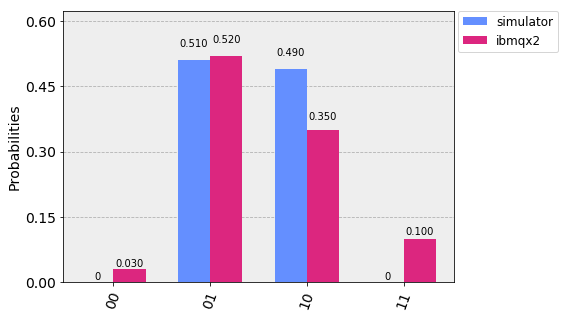

In [185]:
plot_histogram([outcomes_sim,outcomes_q], legend=['simulator', 'ibmqx2'])

Write something on simulator vs real?

In [ ]:
Q prisoner's dilemma has other optimal strategies that don't exist in classical -> Nash equilibriums!
(x-minority game)
other current features ('MW' protocol, etc.)

## Quantum vs Classical Games

So by now you hopefully have a good notion of basic 2x2 classical and quantum games. But what is the real difference between these games? More specifically, if I play the classical game but allow my choices to be randomized, can I reproduce the quantum game? To answer this question, we have to introduce the notion of mixed (i.e. probabilistic) strategies

### Mixed Strategies
A mixed strategy is just a strategy which includes classical stochasticity in it, for example "I choose '0' with 50% probability and '1' with 50% probability". This works for quantum strategies too e.g. "I choose 'X' with 33% probability, 'H' with 33% probability and 'S' with 33% probability."  Already we can start to see that classical games (even when allowing for stochasticity) cannot reproduce quantum games (how do we model the effect of stochastic unitary gates with only classical probabilities?). But let's see it in a concrete example: back to our old friend the Prisoner's Dilemma

### Prisoner's Dilemma Revisited
Let's think the prisoner's dilemma again but this time using mixed strategies. Let's start by spinning up another prisoner's dilemma game to look at the payoff table again.

In [197]:
prisoner_game = Game('prisoner', protocol="Classical")
prisoner_game.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


You may remember from Exercise 1 that there is a dominant strategy for both players in this game. So mixed strategies are not uesful in this case (why would I want to have any chance of choosing the non-dominant strategy?) So how about for the quantum game? Let's just consider pure strategies (i.e. strategies that are not classically stochastic). Is there a dominant strategy there? Naively one could guess that the $X$ strategy is the dominant one, as it corresponds to the classical dominant strategy of choosing '1'. However  

## What next?
This is really cool, what can I do going forward?
1. Help build infrastructure - mixed strategies, more choices etc.
2. Study theory using this toolkit
Ideas we are interested in/working on
Get in touch with us!